# Example using FMM-BEM Algorithm

Import libraries 

In [1]:
from FMM_BEM import read_geo_and_create_quadtree, assem_FMM, eval_sol, surf_plot
import matplotlib.pyplot as plt
import numpy as np

In [2]:
%matplotlib widget

Compute quadtree and boundary conditions

In [3]:
mesh, coords, elems, x_m, y_m, id_dir, id_neu, quadtree, boundary_points = read_geo_and_create_quadtree("files\disk.msh",[0, 1], [2, 3],max_points_quad=1,max_depth=20)

Plotting the quadtree structure

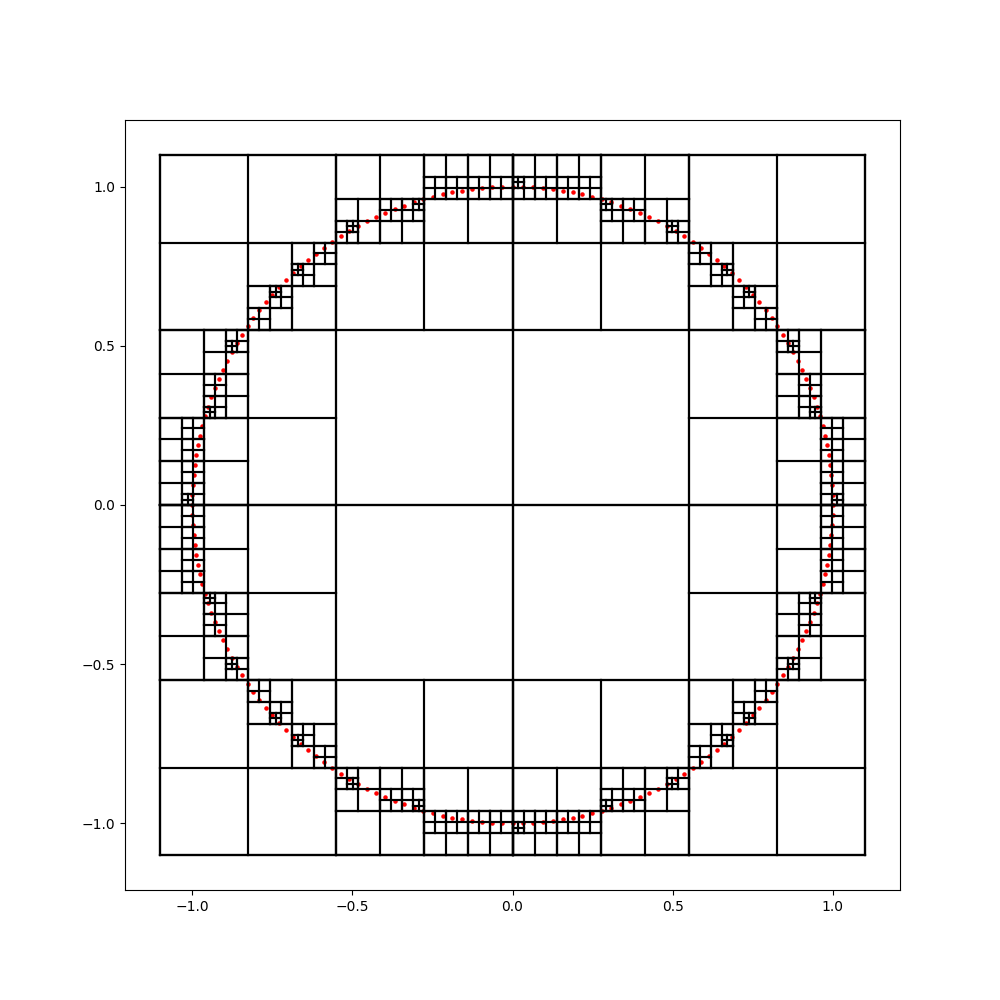

In [4]:
def plot_quadtree(node, ax):
    """ Función recursiva para dibujar los límites del quadtree. """
    xmin, ymin, xmax, ymax = node.bounds
    ax.plot([xmin, xmax], [ymin, ymin], 'k-')
    ax.plot([xmin, xmax], [ymax, ymax], 'k-')
    ax.plot([xmin, xmin], [ymin, ymax], 'k-')
    ax.plot([xmax, xmax], [ymin, ymax], 'k-')

    for child in node.children:
        plot_quadtree(child, ax)

# Visualizar el quadtree
fig, ax = plt.subplots(figsize=(10,10))
plot_quadtree(quadtree, ax)
ax.scatter(boundary_points[:, 0], boundary_points[:, 1], color='red', s=5)  # Dibujar los puntos de la frontera
plt.show()

Assembling problem to obtain $G$ and $H$ matrices

In [5]:
Gmat, Fmat = assem_FMM(coords,elems,quadtree, order=10)


Now to compute the problem, the following process was made

$$[G]\{q\} = [F]\{u\}\, .$$

Since we have mixed boundary conditions we can
split the vectors as 

$$\{q\} = \begin{Bmatrix}q_u\\ q_q\end{Bmatrix}\, ,\quad
\{u\} = \begin{Bmatrix}u_u\\ u_q\end{Bmatrix}\, ,$$

where the subscript $u$ denote elements with Dirichlet
boundary conditions and $q$ with Neumann boundary
conditions.

Thus, we can write the system as

$$\begin{bmatrix}
G_{uu} &G_{uq}\\
G_{qu} &G_{qq}
\end{bmatrix}\begin{Bmatrix}q_u\\ q_q\end{Bmatrix}
= \begin{bmatrix}
F_{uu} &F_{uq}\\
F_{qu} &F_{qq}
\end{bmatrix}\begin{Bmatrix}u_u\\ u_q\end{Bmatrix}\, ,
$$

or

\begin{align}
G_{uu} q_u + G_{uq} q_q = F_{uu} u_u + F_{uq} u_q\, ,\\
G_{qu} q_u + G_{qq} q_q = F_{qu} u_u + F_{qq} u_q\, .
\end{align}

We can rearrange this as

\begin{align}
G_{uu} q_u - F_{uq} q_q = F_{uu} u_u - G_{uq} u_q\, ,\\
G_{qu} q_u - F_{qq} q_q = F_{qu} u_u - G_{qq} u_q\, ,
\end{align}

or

$$\begin{bmatrix}
G_{uu} &-F_{uq}\\
G_{qu} &-F_{qq}
\end{bmatrix}\begin{Bmatrix}q_u\\ u_q\end{Bmatrix}
= \begin{bmatrix}
F_{uu} &-G_{uq}\\
F_{qu} &-G_{qq}
\end{bmatrix}\begin{Bmatrix}u_u\\ q_q\end{Bmatrix}\, ,
$$

where we have moved all unknowns to the left-hand side.

In [6]:
A = np.zeros_like(Fmat)
B = np.zeros_like(Fmat)

In [7]:
A[np.ix_(id_dir, id_dir)] = Gmat[np.ix_(id_dir, id_dir)]
A[np.ix_(id_dir, id_neu)] = -Fmat[np.ix_(id_dir, id_neu)]
A[np.ix_(id_neu, id_dir)] = Gmat[np.ix_(id_neu, id_dir)]
A[np.ix_(id_neu, id_neu)] = -Fmat[np.ix_(id_neu, id_neu)]


In [8]:
B[np.ix_(id_dir, id_dir)] = Fmat[np.ix_(id_dir, id_dir)]
B[np.ix_(id_dir, id_neu)] = -Gmat[np.ix_(id_dir, id_neu)]
B[np.ix_(id_neu, id_dir)] = Fmat[np.ix_(id_neu, id_dir)]
B[np.ix_(id_neu, id_neu)] = -Gmat[np.ix_(id_neu, id_neu)]

In [9]:
theta = np.unwrap(np.arctan2(y_m, x_m))
rhs = np.zeros(elems.shape[0])
rhs[id_dir] = 3*np.cos(6*theta[id_dir])
rhs[id_neu] = -18*np.cos(6*theta[id_neu])


Now, the GMRES method is created 

In [10]:
from scipy.sparse.linalg import gmres, LinearOperator

rhs_modified = B.dot(rhs)

def matvec_A(x):
    result = np.zeros_like(x)
    result[np.ix_(id_dir)] = Gmat[np.ix_(id_dir)].dot(x) - Fmat[np.ix_(id_dir)].dot(x)
    result[np.ix_(id_neu)] = Gmat[np.ix_(id_neu)].dot(x) - Fmat[np.ix_(id_neu)].dot(x)
    return result

shape = (rhs_modified.size, rhs_modified.size)
A_operator = LinearOperator(shape, matvec=matvec_A)
sol,_ = gmres(A_operator, rhs_modified)

Assembling the solution in the bounds

In [11]:
u_bound = np.zeros_like(sol)
q_bound = np.zeros_like(sol)
u_bound[id_dir] = rhs[id_dir]
u_bound[id_neu] = sol[id_neu]
q_bound[id_dir] = sol[id_dir]
q_bound[id_neu] = rhs[id_neu]

Evaluating solution

In [12]:
solution = eval_sol(mesh.points[:, :2], coords, elems, u_bound, q_bound)

# Visualization

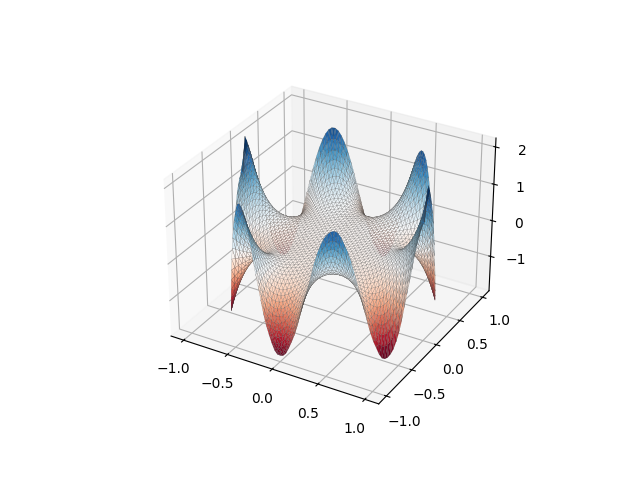

In [13]:
ax = surf_plot(mesh, 4, solution)


# Same problem with Homogeneous conditions

In [14]:
theta = np.unwrap(np.arctan2(y_m, x_m))
rhs = np.zeros(elems.shape[0])
rhs[id_dir] = 1
rhs[id_neu] = 1

In [15]:
from scipy.sparse.linalg import gmres, LinearOperator

rhs_modified = B.dot(rhs)

def matvec_A(x):
    result = np.zeros_like(x)
    result[np.ix_(id_dir)] = Gmat[np.ix_(id_dir)].dot(x) - Fmat[np.ix_(id_dir)].dot(x)
    result[np.ix_(id_neu)] = Gmat[np.ix_(id_neu)].dot(x) - Fmat[np.ix_(id_neu)].dot(x)
    return result

shape = (rhs_modified.size, rhs_modified.size)
A_operator = LinearOperator(shape, matvec=matvec_A)
sol,_ = gmres(A_operator, rhs_modified)

In [16]:
u_bound = np.zeros_like(sol)
q_bound = np.zeros_like(sol)
u_bound[id_dir] = rhs[id_dir]
u_bound[id_neu] = sol[id_neu]
q_bound[id_dir] = sol[id_dir]
q_bound[id_neu] = rhs[id_neu]

In [17]:
solution = eval_sol(mesh.points[:, :2], coords, elems, u_bound, q_bound)

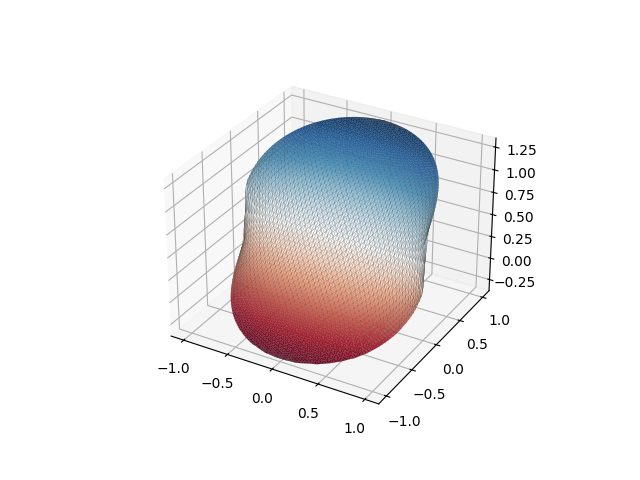

In [18]:
ax = surf_plot(mesh, 4, solution)
